In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import seaborn as sns
import scipy.stats as st
import os
import re

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
data = pd.read_csv('fea_data_1207.csv', sep=',')
data.head()

,unit,ts,qty,geography,product,original,weight,date,year,month,monthofyear,day,dayofyear,weekofyear,weekday,quarter,is_wknd,is_month_start,is_month_end,yesterday_qty,before_yesterday_qty,last_week_qty,last_14day_qty,qty_rolling7_mean,qty_rolling7_max,qty_rolling7_min,qty_rolling7_std,qty_rolling7_skew,qty_rolling7_kurt,qty_rolling7_corr,qty_rolling14_mean,qty_rolling14_max,qty_rolling14_min,qty_rolling14_std,qty_rolling14_skew,qty_rolling14_kurt,qty_rolling14_corr,qty_ewm_mean,qty_ewm_std,qty_ewm_corr,date_start,times,1807ffa2c1c84035f4346c3364104dd1,1de8e43efce0cb9161ac2093f75166c8,3241cf89eaf210f13321fe6280c7d172,450a7d37ed3260ce3e9ea79cc40f11a5,45fe7a01980958e559fa0473c20c8c58,579cf4cbf3d63c78deffc623c0de643f,5cc8015f03554313900f069182bdaf9c,646f301a50470456f3e7793f6b16ca76,6c46c9c5d3ef936b4c8d6d8f9851e837,814119e4a116199cf494768f31987158,93a97f63f0a573483d49c58dc02c1341,95feb3e180f99fa2f9908030bc02ac48,a95738cb3a3c4236b858683b406dea98,ae7d2d22786beebc5981b93c226e2aba,b04c1602cb78c1c4cf72dd7c0ce7d837,ba569a9ecbaa99645f9baf060d5061e7,be55b932f63b0feda2a190154290d4aa,db9e166331f89037c1b3590adfaa18d4,f517d6345d758010f5782a62b4dfe69b,last_quarter,last_monthofyear,last_weekofyear,quarter_std,quarter_min,quarter_max,quarter_median,quarter_min_max,quarter_sum,month_std,month_min,month_max,month_median,month_min_max,month_sum,week_std,week_min,week_max,week_median,week_min_max,week_sum,unit_label,geography_label,product_label,unit_count,geography_count,product_count,unit_std,unit_min,unit_max,unit_median,unit_min_max,unit_sum
0,04b155599672da2f35abd187df4b7d3f,2018-06-06,-14.4,36ab7b000da26b0547bfc3c3fdf143dc,ae7d2d22786beebc5981b93c226e2aba,train,0.061,2018-06-06,2018,6,2018-6,6,157,23,2,2,0,0,0,81.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.600,NaN,NaN,2018-06-05,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,2018-6,23.0,293.0,-1473.0,40.8,18.8,1514.0,-983.5,293.0,-1473.0,40.8,18.8,1514.0,-983.5,21.95,-14.4,35.6,3.9,50.0,39.2,12,13,13,1098.0,11610.0,5428.0,449.0,-2608.0,3308.0,26.9,5916.0,10516.4
1,04b155599672da2f35abd187df4b7d3f,2018-06-07,-14.2,36ab7b000da26b0547bfc3c3fdf143dc,ae7d2d22786beebc5981b93c226e2aba,train,0.061,2018-06-07,2018,6,2018-6,7,158,23,3,2,0,0,0,-14.4,81.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.830,67.900,1.0,2018-06-05,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,2018-6,23.0,293.0,-1473.0,40.8,18.8,1514.0,-983.5,293.0,-1473.0,40.8,18.8,1514.0,-983.5,21.95,-14.4,35.6,3.9,50.0,39.2,12,13,13,1098.0,11610.0,5428.0,449.0,-2608.0,3308.0,26.9,5916.0,10516.4
2,04b155599672da2f35abd187df4b7d3f,2018-06-08,-9.6,36ab7b000da26b0547bfc3c3fdf143dc,ae7d2d22786beebc5981b93c226e2aba,train,0.061,2018-06-08,2018,6,2018-6,8,159,23,4,2,1,0,0,-14.2,-14.4,NaN,NaN,33.620,81.6,-14.4,43.06,1.732025,NaN,1.0,38.97,81.6,-14.4,39.80,1.732025,NaN,1.0,-13.984,15.130,1.0,2018-06-05,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,2018-6,23.0,293.0,-1473.0,40.8,18.8,1514.0,-983.5,293.0,-1473.0,40.8,18.8,1514.0,-983.5,21.95,-14.4,35.6,3.9,50.0,39.2,12,13,13,1098.0,11610.0,5428.0,449.0,-2608.0,3308.0,26.9,5916.0,10516.4
3,04b155599672da2f35abd187df4b7d3f,2018-06-09,17.4,36ab7b000da26b0547bfc3c3fdf143dc,ae7d2d22786beebc5981b93c226e2aba,train,0.061,2018-06-09,2018,6,2018-6,9,160,23,5,2,1,0,0,-9.6,-14.2,NaN,NaN,24.520,81.6,-14.4,38.10,1.986929,3.954538,1.0,27.94,81.6,-14.4,32.30,1.986929,3.954538,1.0,-9.820,4.582,1.0,2018-06-05,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,2018-6,23.0,293.0,-1473.0,40.8,18.8,1514.0,-983.5,293.0,-1473.0,40.8,18.8,1514.0,-983.5,21.95,-14.4,35.6,3.9,50.0,39.2,12,13,13,1098.0,11610.0,5428.0,449.0,-2608.0,3308.0,26.9,5916.0,10516.4
4,04b155599672da2f35abd187df4b7d3f,2018-06-10,35.6,36ab7b000da26b0547bfc3c3fdf143dc,ae7d2d22786beebc5981b93c226e2aba,train,0.061,2018-06-10,2018,6,2018-6,10,161,23,6,2,1,0,0,17.4,-9.6,NaN,NaN,10.984,81.6,-14.4,35.70,1.739166,2.821168,1.0,22.05,81.6,-14.4,28.11,1.739166,2.821168,1.0,16.030,19.250,1.0,2018-06-05,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501012 entries, 0 to 501011
Data columns (total 94 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   unit                              501012 non-null  object 
 1   ts                                501012 non-null  object 
 2   qty                               501012 non-null  float64
 3   geography                         501012 non-null  object 
 4   product                           501012 non-null  object 
 5   original                          501012 non-null  object 
 6   weight                            501012 non-null  float64
 7   date                              501012 non-null  object 
 8   year                              501012 non-null  int64  
 9   month                             501012 non-null  int64  
 10  monthofyear                       501012 non-null  object 
 11  day                               501012 non-null  i

In [4]:
# 压缩内存
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df = reduce_mem_usage(data)

Memory usage of dataframe is 359.31 MB
Memory usage after optimization is: 116.11 MB
Decreased by 67.7%


<AxesSubplot:>

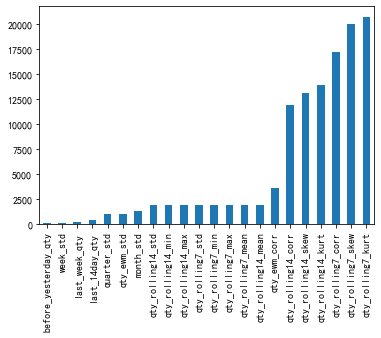

In [6]:
# nan可视化
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [7]:
missing

before_yesterday_qty       29
week_std                  117
last_week_qty             174
last_14day_qty            377
quarter_std               922
qty_ewm_std               927
month_std                1249
qty_rolling14_std        1854
qty_rolling14_min        1854
qty_rolling14_max        1854
qty_rolling7_std         1854
qty_rolling7_min         1854
qty_rolling7_max         1854
qty_rolling7_mean        1854
qty_rolling14_mean       1854
qty_ewm_corr             3593
qty_rolling14_corr      11865
qty_rolling14_skew      13112
qty_rolling14_kurt      13900
qty_rolling7_corr       17158
qty_rolling7_skew       19912
qty_rolling7_kurt       20700
dtype: int64

In [8]:
df.columns

Index(['unit', 'ts', 'qty', 'geography', 'product', 'original', 'weight',
       'date', 'year', 'month', 'monthofyear', 'day', 'dayofyear',
       'weekofyear', 'weekday', 'quarter', 'is_wknd', 'is_month_start',
       'is_month_end', 'yesterday_qty', 'before_yesterday_qty',
       'last_week_qty', 'last_14day_qty', 'qty_rolling7_mean',
       'qty_rolling7_max', 'qty_rolling7_min', 'qty_rolling7_std',
       'qty_rolling7_skew', 'qty_rolling7_kurt', 'qty_rolling7_corr',
       'qty_rolling14_mean', 'qty_rolling14_max', 'qty_rolling14_min',
       'qty_rolling14_std', 'qty_rolling14_skew', 'qty_rolling14_kurt',
       'qty_rolling14_corr', 'qty_ewm_mean', 'qty_ewm_std', 'qty_ewm_corr',
       'date_start', 'times', '1807ffa2c1c84035f4346c3364104dd1',
       '1de8e43efce0cb9161ac2093f75166c8', '3241cf89eaf210f13321fe6280c7d172',
       '450a7d37ed3260ce3e9ea79cc40f11a5', '45fe7a01980958e559fa0473c20c8c58',
       '579cf4cbf3d63c78deffc623c0de643f', '5cc8015f03554313900f069182bdaf9c',
 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501012 entries, 0 to 501011
Data columns (total 94 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   unit                              501012 non-null  object 
 1   ts                                501012 non-null  object 
 2   qty                               501012 non-null  float16
 3   geography                         501012 non-null  object 
 4   product                           501012 non-null  object 
 5   original                          501012 non-null  object 
 6   weight                            501012 non-null  float16
 7   date                              501012 non-null  object 
 8   year                              501012 non-null  int16  
 9   month                             501012 non-null  int8   
 10  monthofyear                       501012 non-null  object 
 11  day                               501012 non-null  i

In [10]:
col_list = df.columns.tolist()
col_list.remove('qty')
col_list.remove('original')
col_list.remove('date_start')
col_list.remove('unit')
col_list.remove('geography')
col_list.remove('product')
col_list.remove('ts')
col_list.remove('monthofyear')
col_list.remove('last_monthofyear')


In [11]:
col_list.remove('date')

In [12]:
df['unit'] = df['unit'].astype('category')
df['geography'] = df['geography'].astype('category')
df['product'] = df['product'].astype('category')
df['date_start'] = df['date_start'].astype('category')
df['monthofyear'] = df['monthofyear'].astype('category')

In [13]:
used_features = col_list

In [14]:
#df['unit'] = df['unit'].astype('str')

In [15]:
#df['geography'] = df['geography'].astype('str')
#df['product'] = df['product'].astype('str')

In [16]:
cate_cols = ['date_start', 'unit', 'geography', 'product', 'monthofyear']
#cate_cols=''

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501012 entries, 0 to 501011
Data columns (total 94 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   unit                              501012 non-null  category
 1   ts                                501012 non-null  object  
 2   qty                               501012 non-null  float16 
 3   geography                         501012 non-null  category
 4   product                           501012 non-null  category
 5   original                          501012 non-null  object  
 6   weight                            501012 non-null  float16 
 7   date                              501012 non-null  object  
 8   year                              501012 non-null  int16   
 9   month                             501012 non-null  int8    
 10  monthofyear                       501012 non-null  category
 11  day                               50101

In [42]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import gc

drop_col = ['ts', 'original', 'date', 'last_monthofyear', 'qty']

train = df[df['original'] == 'train']
labels = np.array(train['qty'].values.tolist())
train.drop(drop_col, axis=1, inplace=True)
test = df[df['original'] == 'test']
test_label = test['qty'].values.tolist()
test.drop(drop_col, axis=1, inplace=True)

used_features = importance_fea
ts_folds = TimeSeriesSplit(n_splits = 5)
N_round = 10000
Verbose = 500
Early_Stopping_Rounds = 100
target = 'qty'

params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'learning_rate': 0.001,
    'num_leaves': 2 ** 5,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 66,
    'feature_fraction': 0.7,
    'feature_fraction_seed': 66,
    'max_bin': 100,
    'max_depth': 10,
    'metric': {'l2', 'l1'},
    'verbose': -1
}

for fold_n, (train_index, valid_index) in enumerate(ts_folds.split(train)):
    if fold_n in [0, 1, 2, 3]:  
        continue  
  
    print('Training with validation') 
    trn_data = lgb.Dataset(train.iloc[train_index], label=labels[train_index],
                          categorical_feature=cate_cols)  
    val_data = lgb.Dataset(train.iloc[valid_index], label=labels[valid_index],
                          categorical_feature=cate_cols)  
    clf = lgb.train(params, trn_data, num_boost_round=N_round, valid_sets=[trn_data, val_data], verbose_eval=Verbose,  
    early_stopping_rounds=Early_Stopping_Rounds)
    val = clf.predict(train.iloc[valid_index])   
    mae_ = mean_absolute_error(labels[valid_index], val)  
  
    print('MAE: {}'.format(mae_))  
  
    print("ReTraining on all data")  
    gc.enable()  
    del trn_data, val_data  
    gc.collect()  
    Best_iteration = clf.best_iteration  
    print("Best_iteration: ", Best_iteration)  
    trn_data = lgb.Dataset(train, label=labels, categorical_feature=cate_cols)  
    clf = lgb.train(params, trn_data, num_boost_round=int(Best_iteration * 1.2))
  #valid_sets=[trn_data], verbose_eval=Verbose)  
  #pred = clf.predict(test[used_features])

Training with validation
Training until validation scores don't improve for 100 rounds
[500]	training's l2: 15490.9	training's l1: 29.4516	valid_1's l2: 3371.38	valid_1's l1: 11.4906
[1000]	training's l2: 13706.6	training's l1: 27.3861	valid_1's l2: 3004.71	valid_1's l1: 10.3362
[1500]	training's l2: 12552.3	training's l1: 26.2631	valid_1's l2: 2806.35	valid_1's l1: 9.71881
[2000]	training's l2: 11719.2	training's l1: 25.627	valid_1's l2: 2675.05	valid_1's l1: 9.4322
[2500]	training's l2: 11068.1	training's l1: 25.2049	valid_1's l2: 2586.26	valid_1's l1: 9.27686
[3000]	training's l2: 10555.8	training's l1: 24.8462	valid_1's l2: 2529.62	valid_1's l1: 9.14724
[3500]	training's l2: 10119.6	training's l1: 24.5249	valid_1's l2: 2488.2	valid_1's l1: 9.03334
[4000]	training's l2: 9735.66	training's l1: 24.2785	valid_1's l2: 2455.34	valid_1's l1: 8.98557
[4500]	training's l2: 9390.94	training's l1: 24.0691	valid_1's l2: 2432.8	valid_1's l1: 8.9683
Early stopping, best iteration is:
[4542]	trai

In [43]:
pred = clf.predict(test)
mae_test = mean_absolute_error(test_label, pred) 
mse_test = mean_squared_error(test_label, pred) 
print('测试集MAE: {}'.format(mae_test))
print('测试集MSE: {}'.format(mse_test))

测试集MAE: 20.25174534263454
测试集MSE: 6133.772280531


In [32]:
def feature_importance(gbm):
    importance = gbm.feature_importance(importance_type='gain')
    names = gbm.feature_name()
    print("-" * 10 + 'feature_importance:')
    no_weight_cols = []
    name_lis = []
    score_lis = []
    for name, score in sorted(zip(names, importance), key=lambda x: x[1], reverse=True):
        if score <= 1e-8:
            no_weight_cols.append(name)
        else:
            print('{}: {}'.format(name, score))
            name_lis.append(name)
            score_lis.append(score)
    print("no weight columns: {}".format(no_weight_cols))
    return name_lis, score_lis

In [33]:
name_lis, score_lis = feature_importance(clf)

----------feature_importance:
week_sum: 88001900855.0
qty_rolling7_mean: 22684771152.0
weekday: 20816629773.0
week_max: 18815454665.0
yesterday_qty: 15281462084.0
week_median: 14325788060.0
qty_rolling14_skew: 12233152340.0
week_min: 11582269852.0
week_std: 11153566970.0
qty_rolling14_kurt: 9837952054.0
before_yesterday_qty: 9636148250.0
monthofyear: 9123202180.0
qty_rolling7_skew: 9085278600.0
unit: 8143130747.0
day: 8072346598.0
month_max: 7918647080.0
week_min_max: 7682028211.0
qty_rolling7_kurt: 7205346720.0
qty_rolling7_max: 6944704937.0
qty_ewm_mean: 6229290265.0
dayofyear: 5681163280.0
qty_rolling7_min: 5492845298.0
quarter_max: 4994976510.0
qty_rolling14_corr: 4394541720.0
month_sum: 4245475540.0
month_min: 4213263600.0
qty_ewm_std: 3921633174.0
quarter_min_max: 3501235760.0
qty_rolling14_max: 3221205158.0
last_week_qty: 2999399477.0
qty_rolling14_mean: 2969304680.0
month_min_max: 2893758540.0
weekofyear: 2812743390.0
quarter_std: 2598966070.0
qty_rolling7_std: 2552034540.0
las

In [41]:
importance_fea = name_lis[:55]
#name_lis[55]

all_fea = data.columns.tolist()[:6] + importance_fea + ['date_start']
tree_data = data[all_fea]
tree_data.head()

tree_data.to_pickle('tree_data.pkl')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]),
 [Text(0, 0, 'week_sum'),
  Text(1, 0, 'qty_rolling7_mean'),
  Text(2, 0, 'weekday'),
  Text(3, 0, 'week_max'),
  Text(4, 0, 'yesterday_qty'),
  Text(5, 0, 'week_median'),
  Text(6, 0, 'qty_rolling14_skew'),
  Text(7, 0, 'week_min'),
  Text(8, 0, 'week_std'),
  Text(9, 0, 'qty_rolling14_kurt'),
  Text(10, 0, 'before_yesterday_qty'),
  Text(11, 0, 'monthofyear'),
  Text(12, 0, 'qty_rolling7_skew'),
  Text(13, 0, 'unit'),
  Text(14, 0, 'day'),
  Text(15, 0, 'month_max'),
  Text(16, 0, 'week_min_max'),
  Text(17, 0, 'qty_rolling7_kurt'),
  Text(18, 0, 'qty_rolling7_max'),
  Text(19, 0, 'qty_ewm_mean'),
  Text(20, 0, 'dayofyear'),
  Text(21, 0, 'qty_rolling7

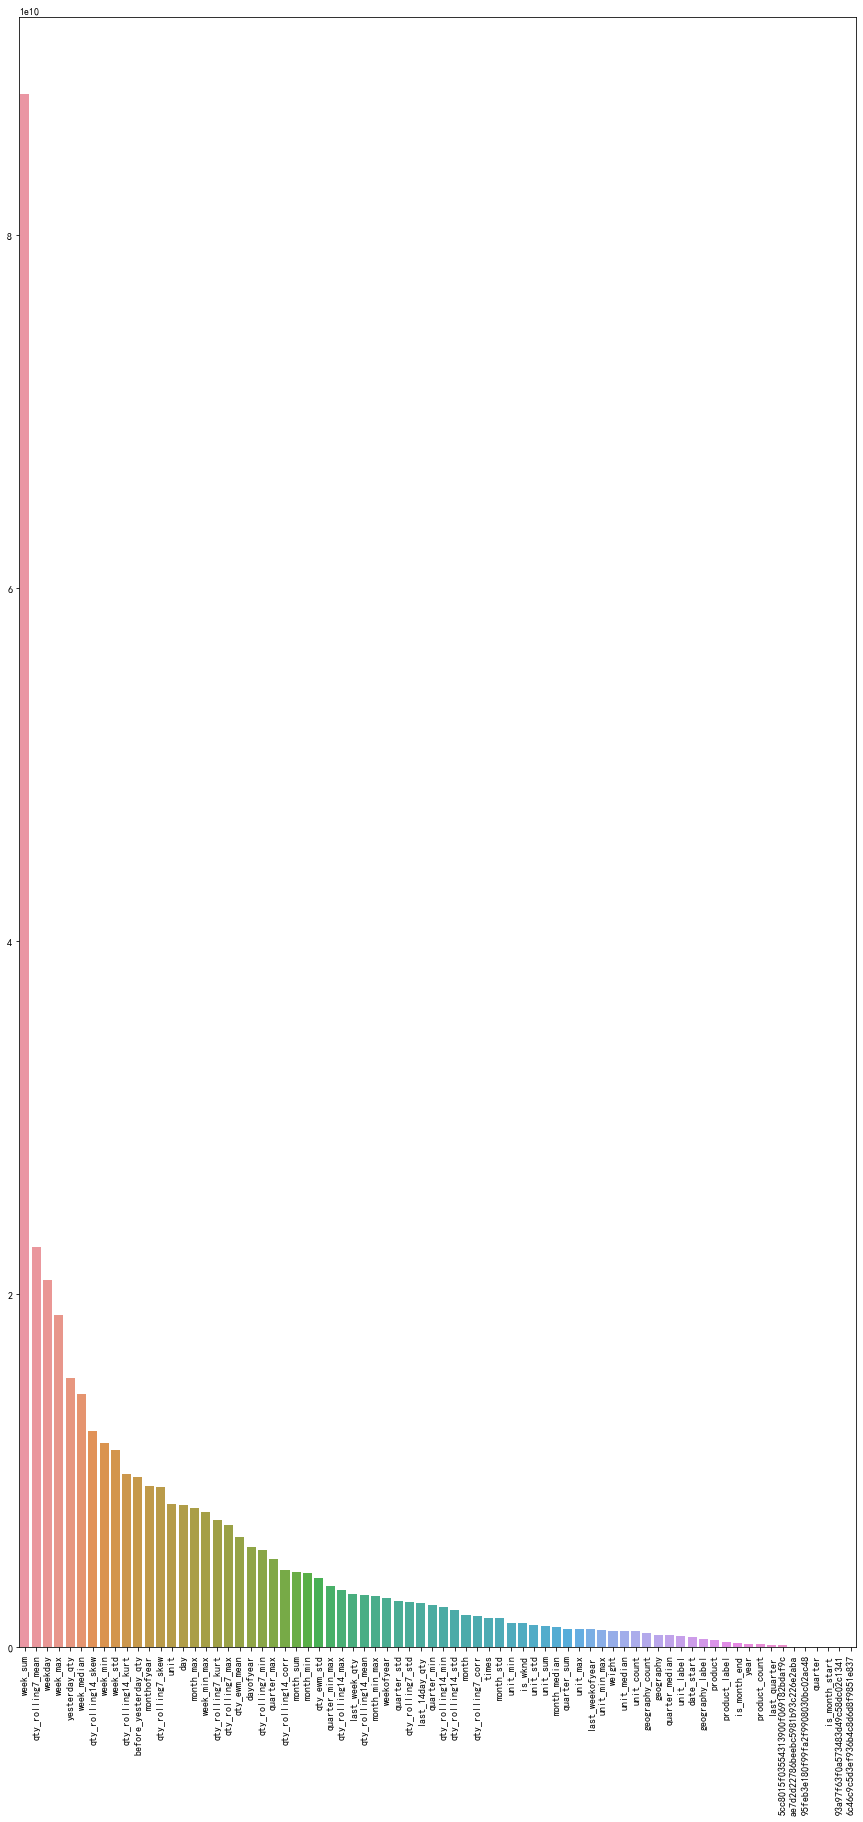

In [34]:
plt.figure(figsize=(15, 30))
sns.barplot(x=name_lis, y=score_lis)
plt.xticks(rotation=90)

mean_squared_error(mse_qty_diff['qty_fiff'][1:], mse_qty_diff['qty_pre_fiff'][1:]) 

In [44]:
pred[:10]

array([ 0.54414319,  0.54414319,  0.54013304,  0.22984465, -0.01636102,
       -0.01636102,  0.54414319,  0.54414319,  0.54414319,  0.54013304])

In [45]:
pre = pred.tolist()

In [46]:
test.head()

,unit,geography,product,weight,year,month,monthofyear,day,dayofyear,weekofyear,weekday,quarter,is_wknd,is_month_start,is_month_end,yesterday_qty,before_yesterday_qty,last_week_qty,last_14day_qty,qty_rolling7_mean,qty_rolling7_max,qty_rolling7_min,qty_rolling7_std,qty_rolling7_skew,qty_rolling7_kurt,qty_rolling7_corr,qty_rolling14_mean,qty_rolling14_max,qty_rolling14_min,qty_rolling14_std,qty_rolling14_skew,qty_rolling14_kurt,qty_rolling14_corr,qty_ewm_mean,qty_ewm_std,qty_ewm_corr,date_start,times,1807ffa2c1c84035f4346c3364104dd1,1de8e43efce0cb9161ac2093f75166c8,3241cf89eaf210f13321fe6280c7d172,450a7d37ed3260ce3e9ea79cc40f11a5,45fe7a01980958e559fa0473c20c8c58,579cf4cbf3d63c78deffc623c0de643f,5cc8015f03554313900f069182bdaf9c,646f301a50470456f3e7793f6b16ca76,6c46c9c5d3ef936b4c8d6d8f9851e837,814119e4a116199cf494768f31987158,93a97f63f0a573483d49c58dc02c1341,95feb3e180f99fa2f9908030bc02ac48,a95738cb3a3c4236b858683b406dea98,ae7d2d22786beebc5981b93c226e2aba,b04c1602cb78c1c4cf72dd7c0ce7d837,ba569a9ecbaa99645f9baf060d5061e7,be55b932f63b0feda2a190154290d4aa,db9e166331f89037c1b3590adfaa18d4,f517d6345d758010f5782a62b4dfe69b,last_quarter,last_weekofyear,quarter_std,quarter_min,quarter_max,quarter_median,quarter_min_max,quarter_sum,month_std,month_min,month_max,month_median,month_min_max,month_sum,week_std,week_min,week_max,week_median,week_min_max,week_sum,unit_label,geography_label,product_label,unit_count,geography_count,product_count,unit_std,unit_min,unit_max,unit_median,unit_min_max,unit_sum
3196,1305184b1a7634e62b1ea3dc7c5fa81d,3d967bd11c42cd595c050d8cb626f3d6,5cc8015f03554313900f069182bdaf9c,0.001,2021,3,2021-3,2,61,9,1,1,0,0,0,0.000000,0.000000,0.0,0.199951,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,0.008163,0.199951,0.000000,0.083618,2.294821,3.791667,1.0,0.000000,0.000000,1.0,2018-06-05,1001,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,9.0,0.063538,-0.399902,0.199951,0.0,0.600098,-0.199951,0.035919,-0.199951,0.0,0.0,0.199951,-0.199951,0.075623,-0.199951,0.0,0.0,0.199951,-0.199951,68,17,6,1098.0,7144.0,62577.0,0.057343,-0.600098,0.600098,0.0,1.200195,0.6
3197,1305184b1a7634e62b1ea3dc7c5fa81d,3d967bd11c42cd595c050d8cb626f3d6,5cc8015f03554313900f069182bdaf9c,0.001,2021,3,2021-3,3,62,9,2,1,0,0,0,-0.199951,0.000000,0.0,0.199951,-0.012497,0.0,-0.199951,0.071472,-2.645751,7.0,1.0,0.000000,0.199951,-0.199951,0.093689,0.000000,6.500000,1.0,-0.189941,0.141235,1.0,2018-06-05,1002,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,9.0,0.063538,-0.399902,0.199951,0.0,0.600098,-0.199951,0.035919,-0.199951,0.0,0.0,0.199951,-0.199951,0.075623,-0.199951,0.0,0.0,0.199951,-0.199951,68,17,6,1098.0,7144.0,62577.0,0.057343,-0.600098,0.600098,0.0,1.200195,0.6
3198,1305184b1a7634e62b1ea3dc7c5fa81d,3d967bd11c42cd595c050d8cb626f3d6,5cc8015f03554313900f069182bdaf9c,0.001,2021,3,2021-3,4,63,9,3,1,0,0,0,0.000000,-0.199951,0.0,0.000000,-0.024994,0.0,-0.199951,0.071472,-2.645751,7.0,1.0,-0.006123,0.000000,-0.199951,0.065491,-3.741657,14.000000,1.0,-0.009499,0.137817,1.0,2018-06-05,1003,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,9.0,0.063538,-0.399902,0.199951,0.0,0.600098,-0.199951,0.035919,-0.199951,0.0,0.0,0.199951,-0.199951,0.075623,-0.199951,0.0,0.0,0.199951,-0.199951,68,17,6,1098.0,7144.0,62577.0,0.057343,-0.600098,0.600098,0.0,1.200195,0.6
3199,1305184b1a7634e62b1ea3dc7c5fa81d,3d967bd11c42cd595c050d8cb626f3d6,5cc8015f03554313900f069182bdaf9c,0.001,2021,3,2021-3,5,64,9,4,1,1,0,0,0.000000,0.000000,0.0,0.000000,-0.037506,0.0,-0.199951,0.071472,-2.645751,7.0,1.0,-0.010201,0.000000,-0.199951,0.065491,-3.741657,14.000000,1.0,-0.000475,0.031555,1.0,2018-06-05,1004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,9.0,0.063538,-0.399902,0.199951,0.0,0.600098,-0.199951,0.035919,-0.199951,0.0,0.0,0.199951,-0.199951,0.075623,-0.199951,0.0,0.0,0.199951,-0.199951,68,17,6,1098.0,7144.0,62577.0,0.057343,-0.600098,0.600098,0.0,1.200195,0.6
3200,1305184b1a7634e62b1ea3dc7c5fa81d,3d967bd11c42cd595c050d8cb626f3d6,5cc8015f03554313900f069182bdaf9c,0.001,2021,3,2021-3,6,65,9,5,1,1,0,0,0.000000,0.0

In [48]:
ss = df[df['original'] == 'test'][['unit', 'ts']]
ss['qty'] = pre
ss.head()

,unit,ts,qty
3196,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-02,0.544143
3197,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-03,0.544143
3198,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-04,0.540133
3199,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-05,0.229845
3200,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-06,-0.016361


In [55]:
ss[ss['unit'] == '1305184b1a7634e62b1ea3dc7c5fa81d']

,unit,ts,qty
3196,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-02,0.544143
3197,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-03,0.544143
3198,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-04,0.540133
3199,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-05,0.229845
3200,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-06,-0.016361
3201,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-07,-0.016361
3202,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-08,0.544143
3203,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-09,0.544143
3204,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-10,0.544143
3205,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-11,0.540133


ss1 = ss[ss['unit']=='1305184b1a7634e62b1ea3dc7c5fa81d']
ss2 = ss1[ss1['ts'] == '2021-03-02'].index.tolist()[0]
ss2

In [54]:
test_B['qty_diff'] = test_B.groupby(['unit'])['qty'].diff(1)
test_B[test_B['unit']=='1305184b1a7634e62b1ea3dc7c5fa81d']

,unit,ts,qty,geography_level,geography,product_level,product,qty_diff
805,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-02,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,NaN
1398,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-03,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
2517,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-04,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
3214,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-05,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
4172,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-06,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
5397,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-07,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
6305,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-08,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
6549,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-09,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
8173,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-10,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0
8854,1305184b1a7634e62b1ea3dc7c5fa81d,2021-03-11,16.768,geography_level_3,3d967bd11c42cd595c050d8cb626f3d6,product_level_2,5cc8015f03554313900f069182bdaf9c,0.0


In [49]:
ss.to_csv('ss_lgb_cat.csv', index=False)

In [50]:
ss['ts'].nunique()

98

In [51]:
test_B = pd.read_csv('./supply_chain_B/demand_test_B.csv', index_col=0)
test_B.head()

,unit,ts,qty,geography_level,geography,product_level,product
5,e527dedfec712d75834a2eacb23e51fc,2021-03-02,44.830729,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
6,157d57374570e571f315087d948053c5,2021-03-02,45.326200,geography_level_3,70b35aead2dac30735d3e5897b287d03,product_level_2,5cc8015f03554313900f069182bdaf9c
11,59e86c3431937f5a8b9b84800abd4310,2021-03-02,12363.398438,geography_level_3,22ec2860549baef5c3e9af46967a3e1d,product_level_2,95feb3e180f99fa2f9908030bc02ac48
31,764d74018c52b2c3872a5a0c1fe4afa5,2021-03-02,3416.457248,geography_level_3,11407e1f167b84f374d9e999a1ed9563,product_level_2,1de8e43efce0cb9161ac2093f75166c8
34,e7cef09a00d6b1fa4166b23690b0e9c8,2021-03-02,3973.500000,geography_level_3,af04e3e5da488f5ca9b5d1d4ce04ebaa,product_level_2,3241cf89eaf210f13321fe6280c7d172


,unit,ts,qty,geography_level,geography,product_level,product
5,e527dedfec712d75834a2eacb23e51fc,2021-03-02,44.830729,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
1746,e527dedfec712d75834a2eacb23e51fc,2021-03-03,47.858073,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
2241,e527dedfec712d75834a2eacb23e51fc,2021-03-04,48.747830,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
3306,e527dedfec712d75834a2eacb23e51fc,2021-03-05,48.313802,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
4534,e527dedfec712d75834a2eacb23e51fc,2021-03-06,48.205295,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
5535,e527dedfec712d75834a2eacb23e51fc,2021-03-07,48.878038,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
6262,e527dedfec712d75834a2eacb23e51fc,2021-03-08,48.585069,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
6536,e527dedfec712d75834a2eacb23e51fc,2021-03-09,48.986545,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
8001,e527dedfec712d75834a2eacb23e51fc,2021-03-10,46.724175,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b
8808,e527dedfec712d75834a2eacb23e51fc,2021-03-11,47.613932,geography_level_3,c22caf17e6d3e86f4ac0d7a603a4d5a6,product_level_2,f517d6345d758010f5782a62b4dfe69b


In [78]:
#真实值串14天
submission = test_B
# 把这里修改为跑出来的结果
submission['qty'] = pre
submission['shift_14']=submission.groupby('unit')['qty'].shift(-14).fillna(0).reset_index().sort_index().set_index('index')
submission = submission[['unit','ts','shift_14']].rename(columns={'shift_14':'qty'})
#按照7天聚合
submission['dt'] = pd.to_datetime(submission['ts'])
submission['weekofyear'] = submission['dt'].dt.weekofyear
submission['year'] = submission['dt'].dt.year
submission_week = submission.copy()
submission_week = submission_week.groupby(['weekofyear','year','unit'],as_index=False).sum()
submission_week['sum_qty'] = submission_week['qty']
submission = pd.merge(submission_week,submission,on = ['weekofyear','year','unit'])
submission['dayofweek'] = submission['dt'].dt.dayofweek
submission = submission[submission['dayofweek']==0]
submission = submission[['unit','ts','sum_qty']].rename(columns={'sum_qty':'qty'})

In [77]:
inventory_info = pd.read_csv('./supply_chain_B/inventory_info_B.csv', sep=',', index_col=0)

In [79]:
init_inventory = inventory_info.set_index(['unit'])['qty'].to_dict()
def consume_init_inventory(arr,init_val):
    remain = init_val
    i = 0
    while remain>0 and i<len(arr):
        arr[i] = max(0,arr[i]-remain)
        remain -= arr[i]
        i+=1
    return arr

r = []
for i,group in submission.groupby('unit'):

    unit = group['unit'].values[0]
    init_val = init_inventory[unit]
    
    group = group.sort_values(by='ts')
    qty_list = group['qty'].values
    qty_list = consume_init_inventory(qty_list,init_val)
    group['qty'] = qty_list
    r.append(group)

submission = pd.concat(r)  

In [80]:
submission.head(30)

,unit,ts,qty
1770,029e6c46cbb94a7b7b9d5d5295113ae6,2021-03-08,23.221051
3835,029e6c46cbb94a7b7b9d5d5295113ae6,2021-03-15,1.852346
5900,029e6c46cbb94a7b7b9d5d5295113ae6,2021-03-22,-36.213255
7965,029e6c46cbb94a7b7b9d5d5295113ae6,2021-03-29,1.930467
10030,029e6c46cbb94a7b7b9d5d5295113ae6,2021-04-05,-30.441534
12095,029e6c46cbb94a7b7b9d5d5295113ae6,2021-04-12,23.697784
14160,029e6c46cbb94a7b7b9d5d5295113ae6,2021-04-19,1.524215
16225,029e6c46cbb94a7b7b9d5d5295113ae6,2021-04-26,16.472131
18290,029e6c46cbb94a7b7b9d5d5295113ae6,2021-05-03,29.866590
20355,029e6c46cbb94a7b7b9d5d5295113ae6,2021-05-10,-20.841606


In [81]:
submission.to_csv('submission_yu.csv', index=False)

In [233]:
submission[submission['unit']=='0025accbb2e3dfbfe6f5b3a4562bdee0']

,unit,ts,qty
